# Summary

----

# Imports

In [1]:
import logging
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
from matplotlib.patches import Patch
from scipy import stats
from textwrap import dedent

In [2]:
%matplotlib inline

In [ ]:
sns.set_context("notebook")

In [3]:
pd.set_option("display.max_columns", 1000)

# Data

In [4]:
%run datasets.ipynb

protherm    :    1,757
strum_q3421 :    3,421
skempi_v1   :    2,025
skempi_v2   :    4,290
ab_bind     :      551


In [5]:
for dataset in DATASETS:
    dataset_len = len(DATASETS[dataset]['data'])
    max_runtime = dataset_len * 3 / 32
    num_arrays = np.ceil(max_runtime / 12) 
    print(f"{dataset:12s}: {max_runtime:7.3f} hours | {num_arrays:4} arrays ({dataset_len:d} rows)")

protherm    : 164.719 hours | 14.0 arrays (1757 rows)
strum_q3421 : 320.719 hours | 27.0 arrays (3421 rows)
skempi_v1   : 189.844 hours | 16.0 arrays (2025 rows)
skempi_v2   : 402.188 hours | 34.0 arrays (4290 rows)
ab_bind     :  51.656 hours |  5.0 arrays (551 rows)


In [6]:
TKPOD_DATA_DIR = Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath('tkpod')
TKPOD_DATA_DIR

# Results

In [42]:
RESULTS = {}

base_list = [
    "interface-p",
    "interface-0",
    "interface-1",
    "interface-2",
    "interface-p1",
    "master.5.no_bind_opt_bind",
    "master.6",
    "master",
]

for base in base_list:
    RESULTS[base] = {}
    for dataset in [
#             "rosetta_ddg-protherm",
#             "rosetta_ddg-strum_q3421",
            "rosetta_ddg-ab_bind",
            "rosetta_ddg-skempi_v2",
    ]:
        dfs = []
        for filename in TKPOD_DATA_DIR.joinpath(base, dataset).glob("*.parquet"):
            df = pq.read_table(filename).to_pandas()
            dfs.append(df)
        if dfs:
            RESULTS[base][dataset] = pd.concat(dfs, sort=False)

# Functions

In [9]:
def make_scatterplot(df, title, size=6):
    df = df[(df['ddg'].abs() < 50) & (df['dg_change'].abs() < 50)]

    fg, axs = plt.subplots(figsize=(size * 1.777, size))

    plt.plot(df['ddg'].values, df['dg_change'].values, 'r.', alpha=0.5)
    plt.title(title)
    plt.xlabel("Experimental ΔΔG")
    plt.ylabel("Rosetta ΔΔG")

    # Stats box
    spearman_r = stats.pearsonr(
        df['ddg'].values,
        df['dg_change'].values,
    )
    text = dedent(f"""
    Pearson R = {spearman_r[0]:.2f}
    P value = {spearman_r[1]:.3f}
    """).strip()
    t = plt.annotate(
        text, fontsize=18 * (size / 6),
        xy=(0.68, 0.85), xycoords='axes fraction', horizontalalignment='left')
    t.set_bbox(dict(facecolor='white', alpha=0.4))

In [10]:
def make_barplot(correlations, title=None):
    fg, ax = plt.subplots(figsize=(8, 0.3 * len(correlations)))
    y_positions = np.arange(len(correlations))
    plt.barh(
        y_positions,
        np.abs(list(zip(*correlations))[1]),
        color=[(sns.color_palette()[0] if t[1] >= 0 else sns.color_palette()[3]) for t in correlations]
    )

    ax.set_yticks(y_positions)
    ax.set_yticklabels([c[0] for c in correlations])
    ax.set_ylim(y_positions[0] - 1, y_positions[-1] + 1)

    ax.set_xlabel('Spearman R')
    ax.set_xlim(0, 0.6)

    ax.set_title(title)

    legend_elements = [
        Patch(facecolor=sns.color_palette()[0], label='positive correlation'),
        Patch(facecolor=sns.color_palette()[3], label='negative correlation'),
    ]
    plt.legend(handles=legend_elements, loc="lower right", ncol=2)

    plt.show()

In [32]:
def spearmanr_by_protein(df, col1, col2):
    corrs = []
    for _, group in df.groupby("pdb_id"):
        group = group.dropna(subset=[col1, col2])
        if len(group) < 3:
            continue
        corr = stats.spearmanr(group[col1], group[col2])[0]
        if pd.notnull(corr):
            corrs.append(corr)
    return np.mean(corrs)

In [12]:
# raise Exception

# Plots

## Combined

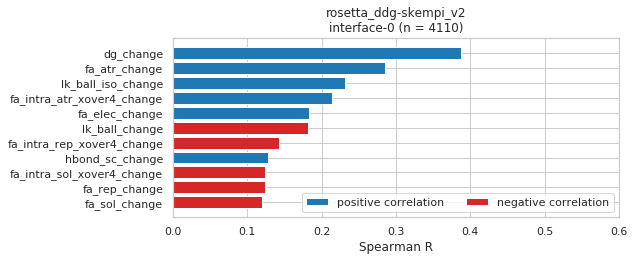

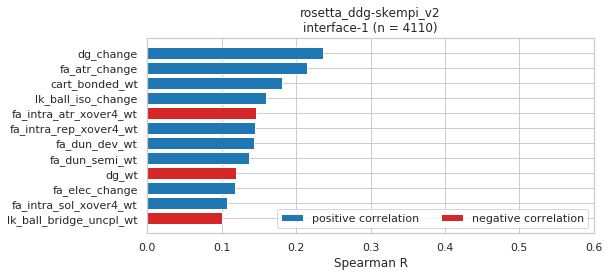

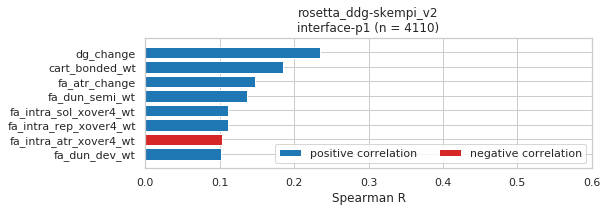

Skipping dataset rosetta_ddg-skempi_v2 because there are no finite correlations.
Skipping dataset rosetta_ddg-skempi_v2 because there are no finite correlations.


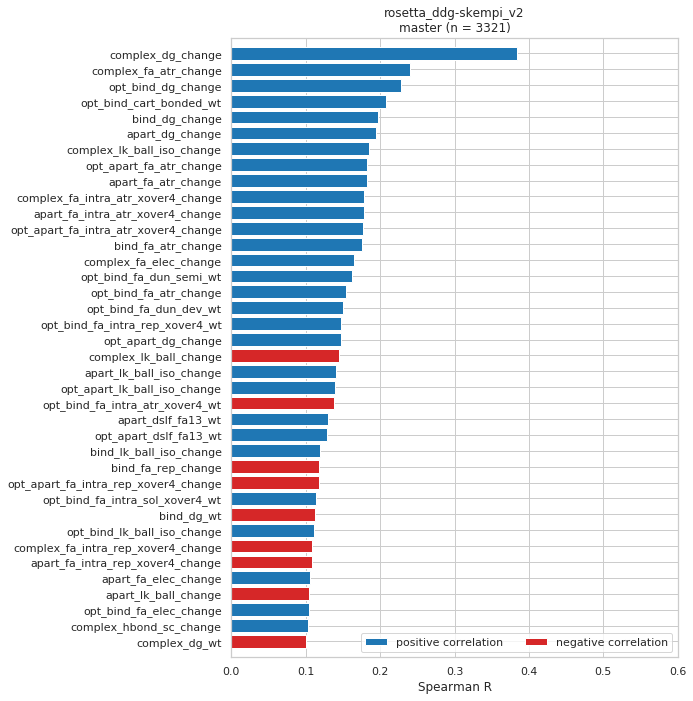

In [41]:
CORE_DATASETS = [
    "rosetta_ddg-protherm",
    "rosetta_ddg-strum_q3421",
]

for base in RESULTS:
    for dataset_name in RESULTS[base]:
        if "skempi_v2" not in dataset_name:
            continue
        df = RESULTS[base][dataset_name]
        df = df.dropna(subset=df.select_dtypes(include=np.number).columns)
        for c in df.select_dtypes(include=np.number).columns:
            if len(df[c].drop_duplicates()) == 1:
                logging.warning(f"Warning: every row in column '{c}' has the same value {df[c].iloc[0]}!")
                del df[c]
        correlations = [
            (c, stats.spearmanr(df[c].values, df['ddg'].values)[0])
#             (c, spearmanr_by_protein(df, c, 'ddg'))
            for c in df.select_dtypes(include=np.number).columns
            if c != 'ddg'
        ]
        correlations = [t for t in correlations if pd.notnull(t[1])]
        correlations.sort(key=lambda t: abs(t[1]))
        correlations = [t for t in correlations if abs(t[1]) > 0.1]
        if not correlations:
            print(f"Skipping dataset {dataset_name} because there are no finite correlations.")
            continue
        with sns.axes_style("whitegrid"):
            make_barplot(correlations, f"{dataset_name}\n{base} (n = {len(df)})")